In [1]:
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_file = os.path.join("workspace", "seqlab-latest", "test.csv")
batch_size = 8
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


Preparing Data test: 100%|██████████| 6961/6961 [01:34<00:00, 73.90it/s] 


In [5]:
# somehow I do PCA analysis.
from models import seqlab, pretrained
from transformers import BertForMaskedLM
import os
import json
import torch

m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(os.path.join("pretrained", "3-new-12w-0")).bert,
    json.load(open(os.path.join("models", "config", "seqlab", "base.lin1.json"), "r"))
)
n = pretrained.DNABERT_SL.from_pretrained(
    os.path.join("pretrained", "3-new-12w-0"),
    json.load(open(os.path.join("models", "config", "seqlab", "base.lin1.json"), "r"))
)

checkpoint = torch.load(
    os.path.join("run", "latest", "latest", "checkpoint.pth"), 
    map_location="cuda:0") # force to cuda:0 device
m.load_state_dict(checkpoint.get("model"))
n.load_state_dict(checkpoint.get("model"))

Some weights of the model checkpoint at pretrained\3-new-12w-0 were not used when initializing DNABERT_SL: ['bert.pooler.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing DNABERT_SL from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DNABERT_SL from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DNABERT_SL were not initialized from the model checkpoint at pretrained\3-new-12w-0 and are newly initial

<All keys matched successfully>

In [ ]:
n.save_pretrained(os.path.join("pretrained", "dnabert-sl-lin1"))

In [27]:
m.train()
n.train()
str(m.state_dict()) == str(n.state_dict())

True

In [31]:
from utils.seqlab import id2label
import pandas as pd
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_log = os.path.join("prediction", "log", "prediction_log_complete.csv")
df = pd.read_csv(test_log)
all_correct_df = df[df["avg_f1_score"] == 1]
path = os.path.join("prediction", "log", "avg_f1_1.csv")
all_correct_df.to_csv(path, index=False)

m.eval()
m.to(device)
arr_token_ids, arr_target_ids, arr_bert_outputs, arr_prediction_ids = [], [], [], []
tokens, target_tokens = [], []
for step, row in tqdm(all_correct_df.iterrows(), total=all_correct_df.shape[0], desc="Testing"):
    # input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
    input_ids = [int(a) for a in row["input_ids"].split(" ")]
    input_ids = [2] + input_ids
    b_input_ids = torch.tensor([input_ids]).to(device)
    attn_mask = [0 for a in range(len(b_input_ids))]
    b_attn_mask = torch.tensor([attn_mask]).to(device)
    target_ids = [int(a) for a in row["target_ids"].split(" ")]
    target_ids = [-100] + target_ids + [-100]
    b_target_ids = torch.tensor([target_ids]).to(device)
    with torch.no_grad():
        b_out, b_out_bert, b_out_head = m(b_input_ids, b_attn_mask)
        for input_ids, target_ids, bert, out in zip(b_input_ids, b_target_ids, b_out_bert, b_out):
            pred_ids = torch.argmax(out, 1)
            for i, j, k, p in zip(input_ids, target_ids, bert, pred_ids):
                arr_token_ids.append(i.item())
                arr_target_ids.append(j.item())
                arr_prediction_ids.append(p.item())
                arr_bert_outputs.append(" ".join([str(a) for a in k.tolist()]))

df = pd.DataFrame(data={
    "token_id": arr_token_ids,
    "prediction_id": arr_prediction_ids,
    "target_id": arr_target_ids,
    "bert_value": arr_bert_outputs
})
df.head(5)

Testing: 100%|██████████| 45/45 [00:53<00:00,  1.18s/it]


,token_id,prediction_id,target_id,bert_value
0,2,0,-100,0.5987125635147095 1.53500497341156 -1.1317837...
1,14,0,0,0.6451724171638489 1.1057522296905518 -0.98850...
2,42,0,0,0.6590017080307007 1.3099629878997803 -1.48478...
3,26,0,0,0.5989748239517212 1.379820466041565 -1.278321...
4,26,0,0,0.6435961127281189 1.45377516746521 -1.3381986...


In [44]:
print(f"all {df.shape}")
special_pred_df = df[df["target_id"] < 0]
print(f"special token prediction {special_pred_df.shape}")
clean_df = df[df["target_id"] >= 0]
print(f"clean prediction {clean_df.shape}")
all_clear_df = clean_df[clean_df["prediction_id"] == clean_df["target_id"]]
print(f"all clear prediction {all_clear_df.shape}")
all_clear_df["prediction_id"].unique()


all (23040, 4)
special token prediction (90, 4)
clean prediction (22950, 4)
all clear prediction (22950, 4)


array([0, 1, 4, 7, 5, 3], dtype=int64)

In [56]:
# consider each element of bert value is feature. oh boy.
feature_df = df.apply(lambda x: x["bert_value"].split(" "), axis=1, result_type="expand")
feature_df.shape

(23040, 768)

In [57]:
feature_count = 768
rename_dictionary = {}
for i in range(feature_count):
    rename_dictionary[i] = f"feature-{i}"
renamed_feature_df = feature_df.rename(columns=rename_dictionary)
renamed_feature_df.head(2)

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,0.5987125635147095,1.53500497341156,-1.1317837238311768,0.7690896391868591,1.7010334730148315,-0.42403700947761536,-0.9997676014900208,-1.1290937662124634,-0.6939066052436829,0.34008389711380005,...,1.822622537612915,-0.44103309512138367,0.8134918808937073,-1.4871634244918823,-0.3357675075531006,-0.4080653786659241,0.3529449701309204,-1.6385308504104614,0.7826378345489502,-0.09787655621767044
1,0.6451724171638489,1.1057522296905518,-0.9885039925575256,1.048960566520691,1.7466413974761963,-0.7470545172691345,-0.8568934798240662,-1.4705466032028198,-0.38563165068626404,0.20808349549770355,...,1.7787373065948486,-0.5066713690757751,0.7648692727088928,-1.0771483182907104,-0.26647019386291504,-0.47476276755332947,0.3734774887561798,-1.6658406257629395,0.762031078338623,-0.3010309040546417


In [60]:
for i in range(768):
    fcol = f"feature-{i}"
    df[fcol] = renamed_feature_df[fcol]
print(df.head(1))
df.to_csv(
    os.path.join("prediction", "log", "token_representation_analysis.csv"),
    index=False
)


   token_id  prediction_id  target_id  \
0         2              0       -100   

                                          bert_value           feature-0  \
0  0.5987125635147095 1.53500497341156 -1.1317837...  0.5987125635147095   

          feature-1            feature-2           feature-3  \
0  1.53500497341156  -1.1317837238311768  0.7690896391868591   

            feature-4             feature-5  ...        feature-758  \
0  1.7010334730148315  -0.42403700947761536  ...  1.822622537612915   

            feature-759         feature-760          feature-761  \
0  -0.44103309512138367  0.8134918808937073  -1.4871634244918823   

           feature-762          feature-763         feature-764  \
0  -0.3357675075531006  -0.4080653786659241  0.3529449701309204   

           feature-765         feature-766           feature-767  
0  -1.6385308504104614  0.7826378345489502  -0.09787655621767044  

[1 rows x 772 columns]


In [73]:
df = pd.read_csv(os.path.join("prediction", "log", "token_representation_analysis.csv"))
df.head(5)

,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,0,-100,0.5987125635147095 1.53500497341156 -1.1317837...,0.598713,1.535005,-1.131784,0.769090,1.701033,-0.424037,...,1.822623,-0.441033,0.813492,-1.487163,-0.335768,-0.408065,0.352945,-1.638531,0.782638,-0.097877
1,14,0,0,0.6451724171638489 1.1057522296905518 -0.98850...,0.645172,1.105752,-0.988504,1.048961,1.746641,-0.747055,...,1.778737,-0.506671,0.764869,-1.077148,-0.266470,-0.474763,0.373477,-1.665841,0.762031,-0.301031
2,42,0,0,0.6590017080307007 1.3099629878997803 -1.48478...,0.659002,1.309963,-1.484780,0.960871,1.864763,-0.668465,...,1.691584,-0.461114,0.895153,-1.292845,-0.188040,-0.621380,0.277574,-1.659623,0.878653,-0.224713
3,26,0,0,0.5989748239517212 1.379820466041565 -1.278321...,0.598975,1.379820,-1.278322,1.004261,1.844362,-0.661420,...,1.783800,-0.437034,1.007878,-1.188710,-0.202203,-0.699765,0.307043,-1.635814,0.751347,-0.356714
4,26,0,0,0.6435961127281189 1.45377516746521 -1.3381986...,0.643596,1.453775,-1.338199,0.994293,1.844836,-0.643741,...,1.755385,-0.491343,1.012347,-1.242417,-0.184293,-0.699391,0.279865,-1.641113,0.768674,-0.376731


In [ ]:
import numpy as np

for i in range(768):
np.max(df[f"feature-{i}"].values), np.min(df[f"feature-{i}"].values)


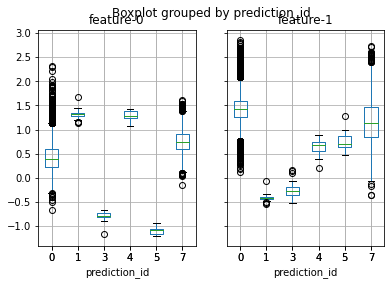

In [76]:
boxplot = df.boxplot(by="prediction_id", column=["feature-0", "feature-1"], layout=(1, 2))

       Col1      Col2  X
0 -0.621494 -0.394166  A
1 -1.638013  0.096526  A
2 -1.213915 -0.075382  A
3 -1.440183 -2.398672  A
4  1.052914  1.446215  A
5 -0.809286 -0.365576  B
6 -0.284127  1.152605  B
7 -0.974620  0.786814  B
8  0.925785  1.093931  B
9  0.369843 -0.716145  B


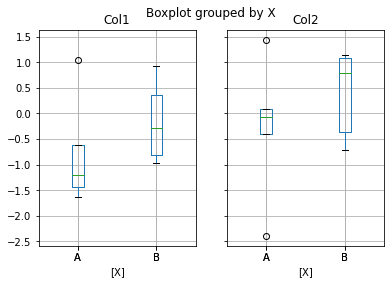

In [71]:
import numpy as np

_df = pd.DataFrame(np.random.randn(10, 2), columns=['Col1', 'Col2'])
_df['X'] = pd.Series(['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B'])
print(_df)
boxplot = _df.boxplot(by='X')

In [29]:
# tokenizer.all_special_ids
# tokenizer.vocab["[CLS]"]
a = [1,2,3,4,5]
b = [99] + a
b

[99, 1, 2, 3, 4, 5]

In [17]:
from transformers import BertTokenizer, BertForMaskedLM
from utils.seqlab import _process_sequence_and_label, id2label, label2id
from models import seqlab
import json
from tqdm import tqdm
from torch import tensor, no_grad, argmax

# get token prediction from categorized dataframes.
import os
import pandas as pd
path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
df = pd.read_csv(path)
print(df.head(5))

tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
model = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(os.path.join("pretrained", "3-new-12w-0")).bert,
    json.load(open(os.path.join("models", "config", "seqlab", "base.lin1.json"), "r"))
)
model.eval()
device = "cuda:0"
model.to(device)
ss_labels = [
    "iiE",
    "iEE", 
    "EEi", 
    "Eii"
]
ss_label_ids = [label2id[a] for a in ss_labels]
arr_tokens, arr_labels, arr_bert_values, arr_pred_tokens = [], [], [], []
for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Testing"):
    with no_grad():
        b_input_ids, b_attention_mask, b_token_type_ids, b_label_ids = _process_sequence_and_label(
            r["input_tokens"],
            r["target_tokens"],
            tokenizer
        )
        b_input_ids = tensor([b_input_ids]).to(device)
        b_attention_mask = tensor([b_attention_mask]).to(device)
        b_label_ids = tensor([b_label_ids]).to(device)
    b_out, b_out_bert, b_out_head = model(
        b_input_ids, 
        b_attention_mask
    )
    b_pred_ids = argmax(b_out, 2)
    # print(b_input_ids.shape, b_label_ids.shape, b_out_bert.shape)
    for input_ids, label_ids, out_bert, pred_ids in zip(b_input_ids, b_label_ids, b_out_bert, b_pred_ids):
        for i, j, k, p in zip(input_ids, label_ids, out_bert, pred_ids):
            label_id = j.item()
            pred_id = p.item()
            if label_id >= 0:
                if label_id in ss_label_ids:
                    token_label = id2label[label_id]
                    token = tokenizer.ids_to_tokens[i.item()]
                    pred_token= id2label[p.item()]
                    bert_values_str = [str(a) for a in k.tolist()]
                    arr_tokens.append(token)
                    arr_pred_tokens.append(pred_token)
                    arr_labels.append(token_label)
                    arr_bert_values.append(" ".join(bert_values_str))

ndf = pd.DataFrame(data={
    "token": arr_tokens,
    "target": arr_labels,
    "prediction": arr_pred_tokens,
    "bert_value": arr_bert_values
})
ndf.head(5)


   label_sequence_id                                       input_tokens  \
0                916  ACT CTT TTT TTT TTC TCC CCC CCT CTT TTT TTT TT...   
1               1108  TGT GTT TTA TAG AGA GAA AAT ATT TTC TCA CAG AG...   
2               1117  GTG TGT GTT TTA TAG AGA GAA AAT ATT TTC TCA CA...   
3               1135  TGG GGT GTG TGT GTT TTA TAG AGA GAA AAT ATT TT...   
4               1144  CTG TGG GGT GTG TGT GTT TTA TAG AGA GAA AAT AT...   

                                      prediction_ids  \
0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 7 ...   
1  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
2  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
3  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
4  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   

                                          target_ids  step  f1_score-iii  \
0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 7 ...  2051             1   
1  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  2286  

Testing: 100%|██████████| 45/45 [00:15<00:00,  2.85it/s]


,token,target,prediction,bert_value
0,AGA,iiE,iiE,0.08756396174430847 0.035568974912166595 0.370...
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...


In [18]:
def _compare_(row):
    target = row["target"]
    prediction = row["prediction"]
    if target == prediction:
        return 1
    else:
        return 0

# true_pred_df = ndf[ndf["target"] == ndf["prediction"]]
# print(true_pred_df.shape) 2, 4

ndf["comparison"] = ndf.apply(lambda x: _compare_(x), axis=1)
ndf[ndf["comparison"] == 1]

,token,target,prediction,bert_value,comparison
0,AGA,iiE,iiE,0.08756396174430847 0.035568974912166595 0.370...,1
80,AGA,iiE,iiE,0.7666749358177185 -0.15378955006599426 1.4997...,1
81,GAA,iEE,iEE,0.26655879616737366 -1.0910930633544922 -0.665...,1


In [20]:
ndf[ndf["comparison"] == 0]

,token,target,prediction,bert_value,comparison
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...,0
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...,0
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...,0
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...,0
5,GGA,iEE,iiE,-0.06882086396217346 0.0999293401837349 1.1488...,0
...,...,...,...,...,...
175,GGT,Eii,iiE,-0.12136223912239075 0.24540439248085022 1.074...,0
176,AGG,iiE,Eii,0.19183388352394104 -0.3378389775753021 0.5174...,0
177,GGA,iEE,EEE,0.17814867198467255 -0.09485137462615967 1.077...,0
178,AGG,EEi,EEE,0.021793914958834648 0.720974862575531 0.61671...,0


In [19]:
ndf.to_csv(
    os.path.join("motif_analysis", "token_analysis", "df-F1=1.csv"), 
    index=False
)

In [21]:
# something weird.
import os
import pandas as pd

path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
tokens, predictions, targets = [], [], []
df = pd.read_csv(path)
for step, r in df.iterrows():
    input_tokens = r["input_tokens"].split(" ")
    prediction_tokens = r["prediction_tokens"].split(" ")
    target_tokens = r["target_tokens"].split(" ")

    for i, j, k in zip(input_tokens, prediction_tokens, target_tokens):
        tokens.append(i)
        predictions.append(j)
        targets.append(k)

df = pd.DataFrame(data={
    "token": tokens,
    "prediction": predictions,
    "target": targets
})
df.head(5)

,token,prediction,target
0,ACT,iii,iii
1,CTT,iii,iii
2,TTT,iii,iii
3,TTT,iii,iii
4,TTC,iii,iii


In [23]:
print(df.shape)
print(df[df["prediction"] == df["target"]].shape)
print(df[df["prediction"] != df["target"]].shape)

(22950, 3)
(22950, 3)
(0, 3)
